In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import get_data, get_dir
import numpy as np
import torch as th
import plot as plot
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tdr import build_tdr, orth_wrt_map
import scipy.stats as stats

base_dir = os.path.join(os.path.expanduser('~'),'Documents','Data','MotorNet')

fontsize_label = 18
fontsize_tick = 15
fontsize_legend = 20
save_fig = '/Users/mahdiyar/Diedrichsenlab Dropbox/Mahdiyar Shahbazi/Conferences/NCM2024_Mahdiyar/figures'

In [29]:
# Load hidden
#folder_name = 'Sim_simple3'
#folder_name = 'Sim_simple_16'
#num_hidden = 16

loss_type = 'lateral'
is_channel = False
T = pd.DataFrame()

N_idx = 16 # 16
F_idx = 25 # 25


for s in [16,32,64,128]:
    print(s)
    #folder_name = 'Sim_simple_' + str(s)
    folder_name = 'Sim_simp_' + str(s)
    num_hidden = s
    #for N_idx in range(2,40,2):
        #print(N_idx)
    for mn in range(0,40):
        if mn==19:
            continue
        model_name = "model{:02d}".format(mn)

        # 0. load muscle space
        n_muscle = 6
        weight_file,_,_= get_dir(folder_name,model_name,'NF1',0)
        W = th.load(weight_file)['fc.weight'].numpy()
        _, _, Vh = np.linalg.svd(W, full_matrices=True)
        V = Vh.T
        P = V[:,:n_muscle] # output potent:  neurons x n_muscle
        #N = V[:,n_muscle:].T # output null space: ...x neurons

        # 1. Load data
        U = get_data(folder_name,model_name,{'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]},[0,8,0,8],num_hidden=num_hidden) # ,batch_size=300,catch_trial_perc=0,condition='train',go_cue_random=False,seed=seed
        data = []
        force = []
        for i in range(len(U)):
            data.append(np.array(U[i]['all_hidden'])[:,N_idx,:])
            force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])
        
        # 1.1 build TDR
        combined_N = np.vstack(data)
        mean_N = np.mean(combined_N, axis=0)

        X = force[0] # NF1 force 
        N = data[0]-mean_N # NF1 hidden activity

        tdr = build_tdr(X,N)

        # 2.2 uniform shift from NF1 to FF1
        us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
        us_orth_norm = orth_wrt_map(us,tdr)
        #us_orth_norm = orth_wrt_map(us,P) # hear i want to try something different


        # 3. perturb hidden
        loss_ff2_p = []
        for dir in [1,-1]:
            d_hidden = th.from_numpy(dir*us_orth_norm.T*1) # 0.6

            # now lets perturb or not and calculate the saving in behavior
            data_p, loss_p = get_data(folder_name,model_name,{'NF2':[0]},[8],num_hidden=num_hidden,
                                    is_channel=is_channel,disturb_hidden=True,t_disturb_hidden=N_idx/100,d_hidden=d_hidden,return_loss=True,batch=[None]) # ,batch=[3000] batch=None
            loss_ff2_p.append(loss_p[0][loss_type].mean())

        
        data_np, loss_np = get_data(folder_name,model_name,{'NF1':[0],'NF2':[0]},[8,8],num_hidden=num_hidden,
                                    is_channel=is_channel,return_loss=True,batch=[None,None]) #,batch=[None,3000] [None,None]
        

        loss_ff1 = loss_np[0][loss_type].mean()
        loss_ff2_np = loss_np[1][loss_type].mean()
        

        d = {'size':[s]*4,'N':[N_idx]*4,'m':[mn]*4,'loss':[loss_ff1,loss_ff2_np,loss_ff2_p[0],loss_ff2_p[1]],'phase':['ff1','ff2','ff2_p+','ff2_p-']}
        T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)


    # # plot
    # n_fig = 1
    # fig,ax = plt.subplots(1,n_fig,figsize=(7*n_fig,5))
    # ax = [ax]

    # plot.plot_simulations(ax[0],xy=data_np[1]['xy'],target_xy=data_np[1]['tg'],vel=None,plot_lat=False)
    # plot.plot_simulations(ax[0],xy=data_p[0]['xy'],target_xy=data_p[0]['tg'],vel=None,plot_lat=False,cmap='plasma')

    # fig, ax = plot.plot_activation(data_p[0]['all_hidden'],data_p[0]['all_muscle']-data_np[1]['all_muscle'],figsize=(15,15))

    #fig, ax = plot.plot_force([data_np[1],data_p[0]],['np','p'],figsize=(10,15))
T.to_csv(base_dir+'/perturb_hidden_lat_size.csv',index=False)

16
32
64
128


Text(0, 0.5, 'Position loss [mm]')

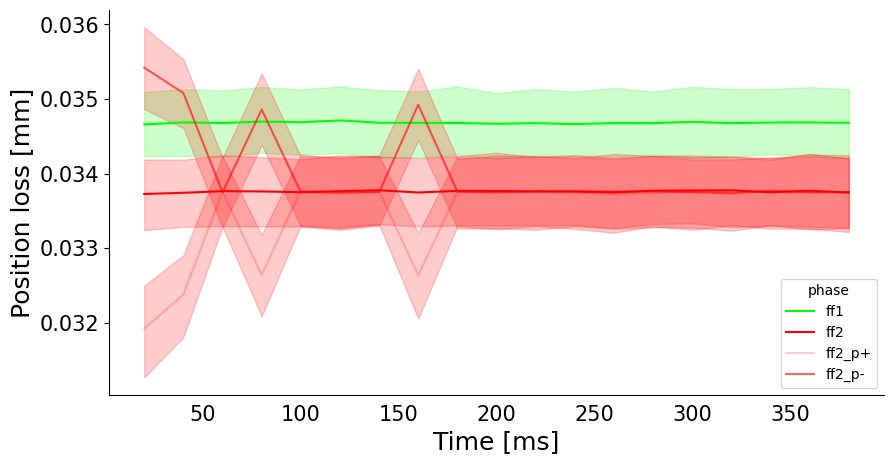

In [27]:
T = pd.read_csv(base_dir+'/perturb_hidden_lat_time.csv')
fig,ax = plt.subplots(1,1,figsize=(10,5))
palette_colors = {'ff1': 'g', 'ff2': 'r', 'ff2_p+': 'r', 'ff2_p-': 'r'}



palette_colors = {
    'ff1': (0, 1, 0, 1),    # Green with 100% opacity
    'ff2': (1, 0, 0, 1),  # Red with 50% opacity
    'ff2_p+': (1, 0, 0, 0.20), # Red with 25% opacity
    'ff2_p-': (1, 0, 0, 0.6)
    # You can also add 'ff2_p-' if needed, e.g., 'ff2_p-': (1, 0, 0, 0.75)
}


sb.lineplot(x='N',y='loss',data=T,hue='phase',palette=palette_colors,ax=ax) # ,errorbar=None

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)

ax.tick_params(bottom = False) 
ax.set_xlabel('Time [ms]', fontsize = fontsize_label)
ax.set_ylabel('Position loss [mm]', fontsize = fontsize_label)

#fig.savefig(os.path.join(save_fig,'perturb_time.pdf'),dpi=300,bbox_inches='tight')

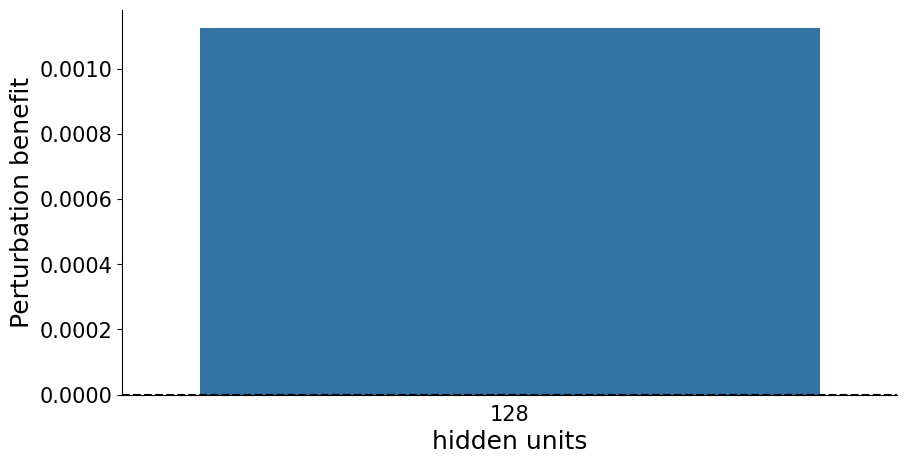

In [22]:
#%matplotlib widget



T = pd.read_csv(base_dir+'/perturb_hidden_lat_size.csv')
#T = T[~T['phase'].isin(['ff1','ff2_p-'])]

# Filter the data for 'ff2' and 'ff2_p+' phases
ff2_data = T[T['phase'] == 'ff2']
ff2_p_data = T[T['phase'] == 'ff2_p+']

merged_data = pd.merge(ff2_data, ff2_p_data, on='size', suffixes=('_ff2', '_ff2_p'))
# Calculate the difference in 'loss'
merged_data['loss_difference'] = merged_data['loss_ff2'] - merged_data['loss_ff2_p']

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sb.barplot(x='size', y='loss_difference', data=merged_data, ax=ax,errorbar=None)

ax.axhline(0, color='black', linestyle='--')

#ax.set_ylim([33,37])  
#ax.set_ylim([-0.5, 0.5])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)

ax.tick_params(bottom = False) 
ax.set_xlabel('hidden units', fontsize = fontsize_label)
ax.set_ylabel('Perturbation benefit', fontsize = fontsize_label)

plt.show()

fig.savefig(os.path.join(save_fig,'p+ben.pdf'),dpi=300,bbox_inches='tight')

In [6]:



#fig,ax = plt.subplots(1,1,figsize=(10,5))
#ax = sb.lineplot(x='size',y='loss',data=T,hue='phase')

#T = pd.read_csv(base_dir+'/perturb_hidden.csv')

In [8]:
T = pd.read_csv(base_dir+'/perturb_hidden.csv')
T['loss']

0      50.096718
1      47.743248
2      60.275890
3      78.319633
4      46.609245
         ...    
315    35.635170
316    36.364727
317    36.066956
318    35.936474
319    36.460964
Name: loss, Length: 320, dtype: float64

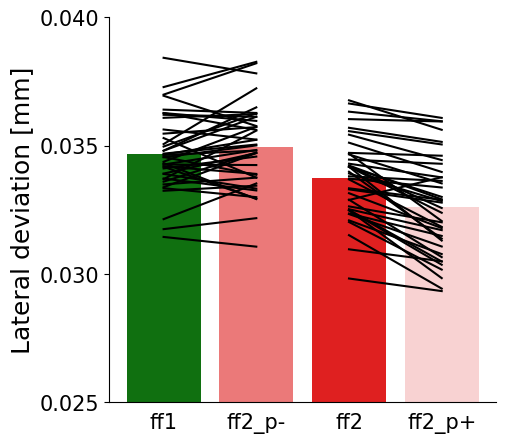

In [21]:
T = pd.read_csv(base_dir+'/perturb_hidden_lat.csv')
fig,ax = plt.subplots(1,1,figsize=(5,5))


T = T[~T['size'].isin([16,32,64])]


palette_colors = {'ff1': 'g', 'ff2': 'r', 'ff2_p+': 'r', 'ff2_p-': 'r'}
opacity_levels = {'ff1': 1, 'ff2': 1, 'ff2_p+': 0.2, 'ff2_p-': 0.6}

order = ['ff1','ff2_p-','ff2','ff2_p+']
# Plot for T_pos on the first subplot
sb.barplot(x='phase', y='loss', data=T, hue='phase', ax=ax,palette=palette_colors,order=order,errorbar=None)

# Assuming there is a 'group_id' or similar to match FF1 and FF2
for group_id, group_data in T.groupby('m'):
    ff1_value = group_data[group_data['phase'] == 'ff1']['loss'].values[0]
    ff2_value = group_data[group_data['phase'] == 'ff2']['loss'].values[0]
    ff2_pos_value = group_data[group_data['phase'] == 'ff2_p+']['loss'].values[0]
    ff2_neg_value = group_data[group_data['phase'] == 'ff2_p-']['loss'].values[0]

    ax.plot(['ff1', 'ff2_p-'], [ff1_value, ff2_neg_value], color='k')
    ax.plot(['ff2', 'ff2_p+'], [ff2_value, ff2_pos_value], color='k')
    


# Adjust the opacity of each bar based on its hue
for bar, hue in zip(ax.patches, T['phase']):
    bar.set_alpha(opacity_levels[hue])


#ax.set_ylim([0.025, 0.04])
#ax.set_ylim([32.5,39])  
#ax.set_ylim([15, 17])



ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


#ax.set_xticklabels([])
ax.set_ylim([0.025,0.04])
ax.set_yticks([0.025,0.03,0.035,0.04])

ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)

ax.tick_params(bottom = False) 
ax.set_xlabel('', fontsize = fontsize_label)
ax.set_ylabel('Lateral deviation [mm]', fontsize = fontsize_label)



fig.savefig(os.path.join(save_fig,'FF2_perturb_lat.pdf'),dpi=300,bbox_inches='tight')
# Display the plot
#plt.tight_layout()  # Adjust the layout
#plt.show()


# L = T.pivot_table(index='m',columns='phase',values='loss')
# t_statistic, p_value = stats.ttest_rel(L['ff2'],L['ff2_p'])
# print("T-statistic:", t_statistic)
# print("P-value:", p_value)

In [8]:
T[T['phase']=='ff2_p+']['loss']

2      0.033762
6      0.032838
10     0.031069
14     0.032905
18     0.030169
22     0.031375
26     0.031786
30     0.035616
34     0.035045
38     0.031707
42     0.032011
46     0.030656
50     0.033973
54     0.032779
58     0.034292
62     0.030495
66     0.035145
70     0.031482
74     0.029332
78     0.032569
82     0.034606
86     0.036079
90     0.033368
94     0.032888
98     0.030359
102    0.031301
106    0.035940
110    0.033001
114    0.031835
118    0.035948
122    0.029837
126    0.030485
130    0.032383
134    0.032061
138    0.033528
142    0.033624
146    0.030775
150    0.034437
154    0.033769
158    0.029430
Name: loss, dtype: float64

In [11]:
t_statistic, p_value = stats.ttest_rel(T[T['phase']=='ff2_p+']['loss'],T[T['phase']=='ff2']['loss'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -8.359008594357656
P-value: 3.16235613571169e-10


In [38]:
t_statistic, p_value = stats.ttest_rel(T['ff1'],T['ff2'])
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.927251732376347
P-value: 0.3654257640171489
